# Data Generation

In [1]:
from collections import namedtuple
class HodgkinHuxley():
    """Full Hodgkin-Huxley Model implemented in Python""" 

    import numpy as np
    import scipy.signal as sps
    import matplotlib.pyplot as plt
    from scipy.integrate import odeint
  
    def __init__(self,time):
        self.t = time

    # HH Constants 
    C_m =   1.0    # [uF/cm^2] membrane capacitance
    g_Na = 120.0    # [mS/cm^2] Sodium (Na) maximum conductance
    g_K  =  36.0    # [mS/cm^2] Postassium (K) maximum conductance
    g_L  =   0.3    # [mS/cm^2] Leak maximum conductance

    E_Na =  50.0    # [mV] Sodium (Na) Nernst reversal potential
    E_K  = -77.0    # [mV] Potassium (K) Nernst reversal potential
    E_L  = -54.387  # [mV] Leak Nernst reversal potential

    def alpha_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.1*(V+40.0)/(1.0 - np.exp(-(V+40.0) / 10.0))

    def beta_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 4*np.exp(-(V+65)/(18))

    def tau_m(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 1/(self.alpha_m(V)+self.beta_m(V))

    def m_0(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return (self.alpha_m(V))/(self.alpha_m(V)+ self.beta_m(V))

    def alpha_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.07*np.exp(-(V+65)/20)

    def beta_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 1/(1+(np.exp(-(V+35)/10)))

    def tau_h(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 1/(self.alpha_h(V)+self.beta_h(V))

    def h_0(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return self.alpha_h(V)/(self.alpha_h(V)+self.beta_h(V))

    def alpha_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.01*((V+55)/(1-np.exp(-(V+55)/10)))

    def beta_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 0.125*np.exp(-(V+65)/80)

    def tau_n(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return 1/(self.alpha_n(V) + self.beta_n(V))

    def n_0(self, V):
        """Channel gating kinetics. Functions of membrane voltage"""
        return self.alpha_n(V)/(self.alpha_n(V)+self.beta_n(V))

    def I_Na(self, V, m, h):
        """
        Membrane current (in uA/cm^2)
        Sodium (Na = element name)
        """
        return self.g_Na*m**3*h*(V-self.E_Na)

    def I_K(self, V, n):
        """
        Membrane current (in uA/cm^2)
        Potassium (K = element name)
        """
        return self.g_K*n**4*(V-self.E_K)
    
    #  Leak 
    def I_L(self, V):
        """
        Membrane current (in uA/cm^2)
        Leak
        """
        return self.g_L*(V-self.E_L)

    def I_inj(self, t, iinj):
        """
        |  :param t: time
        |  :return: step up to 10 uA/cm^2 at t>100
        |           step down to 0 uA/cm^2 at t>200
        |           step up to 35 uA/cm^2 at t>300
        |           step down to 0 uA/cm^2 at t>400
        External Current
        iinj[0] = input current
        iinj[1] = time current starts
        iinj[2] = time current stops
        """
        return iinj[0]*(t>iinj[1]) - iinj[0]*(t>iinj[2])
    
   

    @staticmethod
    def dALLdt(X, t, self):
     
        #dX = np.zeros((4,))
        
        """
        Calculate the change in each of the variables.

        |  :param X:
        |  :param t:
        |  :return: calculate membrane potential & activation variables
        """
        V, m, h, n = X

        dVdt = (self.I_inj(t, self.iinj) - self.I_Na(V, m, h) - self.I_K(V, n) - self.I_L(V) + np.random.random()/10000)/self.C_m
        dmdt = (-(1/self.tau_m(V))*(m - self.m_0(V)))
        dhdt = (-(1/self.tau_h(V))*(h - self.h_0(V)))
        dndt = (-(1/self.tau_n(V)))*(n - self.n_0(V))
        return dVdt, dmdt, dhdt, dndt

    def HH_EX1a(self,iamp,tstep):
        """
        Simulate a Hodgkin Huxley (HH) neuron subject to a single pulse current injection.

        Plot the voltage as a function of time for different current amplitudes.
        What is the spike threshold? 
        Bonus: Does the spike threshold depend on the duration of the pulse?
        
        (Hint: you can use the odeint function to integrate a system of equations.
        Docs: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html)
        Example:
            X = odeint(self.dALLdt, [-65, 0.05, 0.6, 0.32], self.t, args=(self,))
            V = X[:,0]
            m = X[:,1]
            h = X[:,2]
            n = X[:,3]
        Here, the [-65, 0.05, 0.6, 0.32] are the initial values for V, m, h, and n respectively.\
        I used the parameters iamp and tstep to represent the amplitude and the start/stop of
        some external input. You can feel free to define it in a similar fashion, or implement
        your own way of getting the injected current.
        """
        self.iinj = [iamp, tstep[0], tstep[1]]

        X = odeint(self.dALLdt, [-65, 0.05, 0.6, 0.32], self.t, args=(self,))
        V = X[:,0]
        m = X[:,1]
        h = X[:,2]
        n = X[:,3]
       
        x = self.t
        y = V

        plt.plot(x, y, label='Voltage')

        plt.title('HH neuron subject to single pulse current injection')
        plt.xlabel('Time (ms)')
        plt.ylabel('Voltage (mV)')
        plt.legend()
        plt.show()
        
        ap_max = max(y)
        ap_min = min(y)
        total_amplitude = ap_max - ap_min
        max_index = np.where(y == max(y))
        min_index = np.where(y == min(y))
        spike_time = x[108] - x[82]
        #print(x)
        #print(y)
        print(ap_max)
        print(ap_min)
        print(total_amplitude)
        print(str(spike_time) + ' ms')

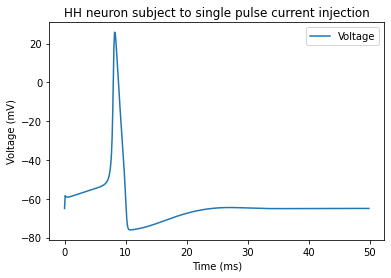

25.87612051437222
-76.07610651126981
101.95222702564203
2.5999999999999996 ms


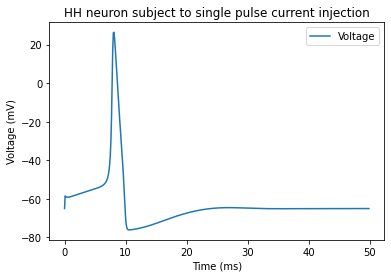

26.40152686412355
-76.08070204120594
102.48222890532949
2.5999999999999996 ms


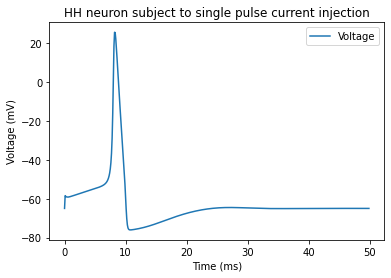

25.776671609098422
-76.0761187167677
101.85279032586612
2.5999999999999996 ms


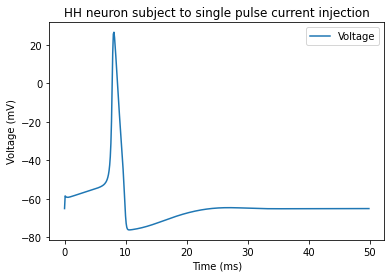

26.55282427279299
-76.07972187557048
102.63254614836347
2.5999999999999996 ms


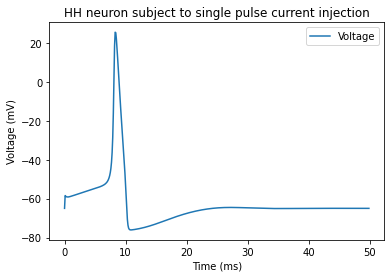

25.470991721179054
-76.07327149889164
101.54426322007069
2.5999999999999996 ms


In [28]:
# You can use the following code to define some input current and call your HH_EX1a function.
import numpy as np
import scipy.signal as sps
import matplotlib.pyplot as plt
from scipy.integrate import odeint

spikes = np.arange(1, 6)
#print(spikes)

for ap in spikes:
    iamp = 68.05026 
    tstep = np.arange(0.0, 50.0, 0.1)
    runner1a = HodgkinHuxley(np.arange(0.0, 50.0, 0.1)) # simulate for 50ms
    runner1a.HH_EX1a(iamp, tstep)

In [ ]:
for ap in spikes:
    iamp = 68.05026 
    tstep = np.arange(0.0, 50.0, 0.1)
    runner1a = HodgkinHuxley(np.arange(0.0, 50.0, 0.1)) # simulate for 50ms
    runner1a.HH_EX1a(iamp, tstep)

## Code for data processing and train/test set creation

In [3]:
!pip3 install torch torchvision

import csv
from numpy import genfromtxt
import numpy as np
import pandas as pd
from random import random
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import math
import sklearn.linear_model

Defaulting to user installation because normal site-packages is not writeable


In [4]:
FS = np.zeros((1438875, 38));
PT = np.zeros((319584, 38));
IT = np.zeros((126470, 38));

In [5]:
# Function to check and remove NaNs from dataset
def dataChecker(arr):
    idxRow = -1
    for row in arr:
        idxRow = idxRow + 1
        for idx in range(len(row)):
            if math.isnan(arr[idxRow,idx]) == True:
                arr[idxRow, idx] = 0
    return arr

In [6]:
# Find max value in the dataset and its index
def maxVal(arr):
    idxRow = -1
    maxVal = -100
    indexes = np.empty(2)
    for row in arr:
        idxRow = idxRow + 1
        for idx in range(len(row)):
            if ((arr[idxRow,idx] > maxVal) and (idx != 0 and idx != 4 and idx != 5 and idx != 6 and idx != 7 and idx != 8)):
                maxVal = arr[idxRow, idx]
                indexes[0] = idxRow
                indexes[1] = idx
    return indexes, maxVal

In [7]:
# Find max value in the dataset and its index
def minVal(arr):
    idxRow = -1
    minVal = 100
    indexes = np.empty(2)
    for row in arr:
        idxRow = idxRow + 1
        for idx in range(len(row)):
            if ((arr[idxRow,idx] < minVal) and (idx != 0 and idx != 4 and idx != 5 and idx != 6 and idx != 7 and idx != 8)):
                minVal = arr[idxRow, idx]
                indexes[0] = idxRow
                indexes[1] = idx
    return indexes, minVal

In [8]:
# Scale all values in the array that are the waveform or waveform-dependent to a range
def scaleVals(arrIn, arrOut, minAllowed, maxAllowed, minValue, maxValue):
    idxRow = -1
    for row in arrIn:
        idxRow = idxRow + 1
        for idx in range(len(row)):
            if(idx != 0 and idx != 4 and idx != 5 and idx != 6 and idx != 7 and idx != 8):
                scaled = (((maxAllowed - minAllowed) * (arrIn[idxRow,idx] - minValue)) / (maxValue - minValue)) + minAllowed
                arrOut[idxRow, idx] = scaled
            else:
                arrOut[idxRow, idx] = arrIn[idxRow,idx]
    return arrOut

In [9]:
# Perform Recursive Feature Elimination to identify the 3 top features
def RFE(arr):
    #data = X, target = Y
    X = arr[:,1:9]
    Y = arr[:,0]
    
    #Feature extraction
    model = sklearn.linear_model.LogisticRegression()
    rfeFeatures = sklearn.feature_selection.RFE(model, 3)
    fit = rfeFeatures.fit(X,Y)
    return fit.ranking_

In [10]:
# Number of waveforms for each neuron cell type
valsFS = 1438775
valsPT = 319484
valsIT = 126460

In [11]:
# Number of rows in each array
rows_FS = valsFS
rows_PT = valsPT
rows_IT = valsIT

In [12]:
# Separation value to split up training:testing sets (67:33)
sep_FS = 2 * rows_FS // 3
sep_PT = 2 * rows_PT // 3
sep_IT = 2 * rows_IT // 3

In [13]:
# Create training sets
col = 38
trainArrSize = sep_FS
train_set_FS = np.empty((trainArrSize,col))
train_set_PT_attr = np.empty((trainArrSize,col))
train_set_IT_attr = np.empty((trainArrSize,col))

In [14]:
# Fill the training sets with the 66% that is already existent (prior to oversampling)
for indFS_init in range(sep_FS):
    train_set_FS[indFS_init, :] = FS[indFS_init,:]

for indPT_init in range(sep_PT):
    train_set_PT_attr[indPT_init, :] = PT[indPT_init,:]

for indIT_init in range(sep_IT):
    train_set_IT_attr[indIT_init, :] = IT[indIT_init,:]

In [15]:
# Fill the test sets to completion
test_set_FS = np.empty((0,col))
test_size_FS = valsFS - sep_FS
test_set_PT = np.zeros((0,col))
test_size_PT = valsPT - sep_PT
test_set_IT = np.zeros((0,col))
test_size_IT = valsIT - sep_IT

test_set_FS = np.append(test_set_FS, FS[sep_FS:valsFS, :], axis = 0)
test_set_PT = np.append(test_set_PT, PT[sep_PT:valsPT, :], axis = 0)
test_set_IT = np.append(test_set_IT, IT[sep_IT:valsIT, :], axis = 0)

In [16]:
# Oversampling the minority with replacement

# Determine how much to add to PT/IT and size of pre-oversampling array
numAdd_PT = sep_FS - sep_PT
numAdd_IT = sep_FS - sep_IT
trainPTArrSize = sep_PT
trainITArrSize = sep_IT

In [17]:
# Randomize attribute-wise (_attr) for all features but the waveform,
# which will be randomized as single unit
for indPT_2 in range(trainPTArrSize,numAdd_PT+trainPTArrSize):
    for attrPT in range(9):
        rand = int(random() * (sep_PT+1))
        train_set_PT_attr[indPT_2,attrPT] = train_set_PT_attr[rand, attrPT]
    rand = int(random() * (sep_PT+1))
    train_set_PT_attr[indPT_2, 9:] = train_set_PT_attr[rand, 9:]

for indIT_2 in range(trainITArrSize,numAdd_IT+trainITArrSize):
    for attrIT in range(9):
        rand = int(random() * (sep_IT+1))
        train_set_IT_attr[indIT_2,attrIT] = train_set_IT_attr[rand, attrIT]
    rand = int(random() * (sep_IT+1))
    train_set_IT_attr[indIT_2, 9:] = train_set_IT_attr[rand, 9:]

In [18]:
# Randomly combine individual training and testing sets into master training and testing sets
train_set_attr = np.empty((trainArrSize * 3, col))
countFS = 0
countPT = 0
countIT = 0
indTrain= 0
while indTrain < (trainArrSize * 3):
    rand = int(random() * 3 + 1)
    if rand == 1 and (countFS + 1 <= trainArrSize):
        train_set_attr[indTrain,:] = train_set_FS[countFS,:]
        countFS = countFS + 1
        indTrain = indTrain + 1
    elif rand == 2 and (countPT + 1 <= trainArrSize):
        train_set_attr[indTrain,:] = train_set_PT_attr[countPT,:]
        countPT = countPT + 1
        indTrain = indTrain + 1
    elif rand == 3 and (countIT + 1 <= trainArrSize):
        train_set_attr[indTrain,:] = train_set_IT_attr[countIT,:]
        countIT = countIT + 1
        indTrain = indTrain + 1

test_set = np.empty((test_size_FS + test_size_PT + test_size_IT, col))
countFS = 0
countPT = 0
countIT = 0
indTest = 0
while indTest < (test_size_FS + test_size_PT + test_size_IT):
    rand = int(random() * 3 + 1)
    if rand == 1 and (countFS + 1 <= test_size_FS):
        test_set[indTest,:] = test_set_FS[countFS,:]
        countFS = countFS + 1
        indTest = indTest + 1
    elif rand == 2 and (countPT + 1 <= test_size_PT):
        test_set[indTest,:] = test_set_PT[countPT,:]
        countPT = countPT + 1
        indTest = indTest + 1
    elif rand == 3 and (countIT + 1 <= test_size_IT):
        test_set[indTest,:] = test_set_IT[countIT,:]
        countIT = countIT + 1
        indTest = indTest + 1

In [19]:
# Remove NaNs in each array
train_set_attr = dataChecker(train_set_attr)
test_set = dataChecker(test_set)

In [20]:
# Scaling inputs to 0-1

#FS, PT, IT = importData()
train_set_attr_scld = np.empty((2877549, 38))
test_set_scld = np.empty((628241, 38))

minValue = -0.00098502
maxValue = 0.0011485

train_set_attr_scld = scaleVals(train_set_attr, train_set_attr_scld, 0, 1, minValue, maxValue)
test_set_scld = scaleVals(test_set, test_set_scld, 0, 1, minValue, maxValue) 

print('training set creation successful')

training set creation successful


# Code for Perceptron Neural Network

In [24]:
class Perceptron(object):
    # The input parameters should be input_size for the number of input neurons, 
    # lr for the learning rate, and epochs for the number of training epochs.

    def __init__(self, input_size, lr=1, epochs=100):
        self.W = np.zeros(input_size+1)
        # add one for bias
        self.epochs = epochs
        self.lr = lr
    
    def activation_fn(self, x):
        #return (x >= 0).astype(np.float32)
        return 1 if x >= 0 else 0

    def predict(self, x):
        # Compute the output of the perceptron given an input x and weights W
        z = self.W.T.dot(x)
        a = self.activation_fn(z)
        return a

    def fit(self, X, d):
        # Train the weights W (including bias) of the perceptron given input data X and desired labels d
        for _ in range(self.epochs):
            for i in range(d.shape[0]):
                x = np.insert(X[i], 0, 1)
                y = self.predict(x)
                e = d[i] - y
                self.W = self.W + self.lr * e * x